# Stochastic Differential Equations in PFJAX

**Martin Lysy, University of Waterloo** 

**January 1, 2022**

## Model Specification

Let $\XX(t) = (X_1(t), \ldots, X_d(t))$ denote a $d$-dimensional process satisfying the stochastic differential equation (SDE)

$$
\ud \XX(t) = \dr(\XX(t), \tth) \ud t + \df(\XX(t), \tth)^{1/2} \ud \BB(t),
$$

where $\dr(\XX, \tth)$ is a $d$-dimensional drift function and $\df(\XX, \tth)$ is a $d \times d$ positive-definite diffusion matrix.  We assume that $\XX(t)$ is measured with error at times $t_n = n \dt$ such that the observed data is $\YY_{0:N} = (\YY_0, \ldots, \YY_N)$ with

$$
\YY_n \ind g(\YY_n \mid \XX_n, \tth),
$$

where $\XX_n = \XX(t_n)$.  

Assume that the initial value of the SDE at time $t_0 = 0$ has the prior distribution $\XX_0 \sim \pi(\XX_0 \mid \tth)$. Then the likelihood function is given by

$$
\mathcal L(\tth \mid \YY_{0:N}) = \int \left[\pi(\XX_0 \mid \tth) \cdot \prod_{n=0}^N g(\YY_n \mid \XX_n, \tth) \cdot \prod_{n=1}^N p(\XX_n \mid \XX_{n-1}, \tth)\right] \ud \XX_{0:N}.
$$

However, this expression requires the SDE transition density $p(\XX_n \mid \XX_{n-1}, \tth)$, which is rarely available in closed form.  Instead, the likelihood function is approximated by the so-called Euler (or Euler-Maruyama) discretization method.  Namely, for $m \ge 1$ let $\XX\up m_n$ denote the value of the SDE at time $t = n \dt/m$, such that $\XX\up m_{mn} = \XX_n = \XX(t_n)$.  As $\dt_m = \dt/m \to 0$, the normal approximation

$$
\begin{aligned}
\XX\up m_n & \sim \N( \XX\up m_{n-1} + \dr(\XX\up m_{n-1}, \tth) \dt_m, \df(\XX\up m_{n-1}, \tth) \dt_m) \\
\iff \XX\up m_n & \sim \varphi(\XX\up m_n \mid \XX\up m_{n-1}, \tth)
\end{aligned}
$$

becomes increasingly accurate.  Thus the Euler approximation of order $m$ (or resolution $m$) to the likelihood function is

$$
\Lhat_m(\tth \mid \YY_{0:N}) = \int \left[\pi(\XX\up m_0 \mid \tth) \cdot \prod_{n=0}^N g(\YY_n \mid \XX\up m_{nm}, \tth) \cdot \prod_{n=1}^{Nm} \varphi(\XX\up m_n \mid \XX\up m_{n-1}, \tth)\right] \ud \XX\up m_{0:Nm},
$$

and we have $\Lhat_m(\tth \mid \YY_{0:N}) \to \mathcal L(\tth \mid \YY_{0:N})$ as $m \to \infty$.

## Particle Filtering

In the notation of PFJAX, the state and measurement variables at time $t$ are given by

$$
\begin{aligned}
x_t & = \XX\up m_{(t-1)m+1:tm}, & y_t & = \YY_t.
\end{aligned}
$$

### Prior on Initial Value

The prior on $x_0 = (\XX\up m_{-m+1}, \ldots, \XX\up m_0)$, is given by

$$
\begin{aligned}
\XX\up m_0 & \sim \pi(\XX\up m_0 \mid \tth), \\
\XX\up m_n & = 0, \ \ \ \ \ -m+1 \le n < 0.
\end{aligned}
$$

In other words, we use the SDE prior for $\XX\up m_0$, and set the dummy variables $\XX\up m_n = 0$ for $n = -m+1, \ldots, -1$.

### Bridge Proposal

Suppose that $x_{t-1} = (\XX\up m_{(t-2)m+1}, \ldots, \XX\up m_{(t-1)m})$ is given, and suppose that the measurement model is 

$$
\YY_t \ind \N(\AA \XX\up m_{tm}, \OOm).
$$

In order to describe the bridge proposal for $x_t = (\XX\up m_{(t-1)m+1}, \ldots, \XX\up m_{tm})$, let us first consider the following formula.  

> **Formula.** If
>
> $$
\begin{aligned}
\WW & \sim \N(\mmu_W, \SSi_W) \\
\XX \mid \WW & \sim \N(\WW + \mmu_{X|W}, \SSi_{X|W}) \\
\YY \mid \XX, \WW & \sim \N(\AA \XX, \OOm),
\end{aligned}
$$
> 
> then 
> 
> $$
\begin{bmatrix} \WW \\ \YY \end{bmatrix} \sim \N\left(\begin{bmatrix} \mmu_W \\ \mmu_{Y} = \AA[\mmu_W + \mmu_{X|W}] \end{bmatrix}, \begin{bmatrix} \SSi_W & \SSi_W \AA' \\ \AA \SSi_W & \SSi_Y = \AA (\SSi_W + \SSi_{X|W}) \AA' + \OOm \end{bmatrix} \right),
$$
> 
> such that
> 
> $$
\WW \mid \YY \sim \N\left(\mmu_W + \SSi_W \AA' \SSi_Y^{-1}(\YY - \mmu_Y), \SSi_W - \SSi_W \AA' \SSi_Y^{-1} \AA \SSi_W \right).
$$

The bridge proposal for $x_t$ then proceeds recursively as follows:

- WLOG let $t = 1$, and assume that for fixed $0 \le n < m-1$ the proposal value $\XX \up m_{(t-1)m+n} = \XX \up m_n$ is given. Now suppose we wish to specify the proposal distribution for $\XX \up m_{n+1}$.

- Pretend that $\XX(t)$ is a Brownian motion with drift for $t \in (\tfrac n m \dt, \dt)$:

    $$
    \ud \XX(t) = \dr_n \ud t + \df_n^{1/2} \ud \BB(t),
    $$
	
	where $\dr_n = \dr(\XX \up m_{n}, \tth)$ and $\df_n = \df(\XX \up m_{n}, \tth)$.  This means that for any $\tfrac n m \dt \le s \le s + u \le \dt$ we have
	
	$$
	\XX(s+u) \mid \XX(s) \sim \N(\XX(s) + u \dr_n, u \df_n),
	$$
    
    To obtain the proposal for $\XX\up m_{n+1}$, we apply the formula to $(\WW, \XX, \YY) = (\XX\up m_{n+1}, \XX\up m_{m}, \YY_1)$, for which we have
	
	$$
	\begin{aligned}
	\XX\up m_{n+1} & \sim \N(\XX\up m_n + \dt_m \dr_n, \dt_m \df_n) \\
	\XX\up m_m \mid \XX \up m_{n+1} & \sim \N(\XX \up m_{n+1} + k \dt_m \dr_n , k \dt_m \df_n) \\
	\YY_1 \mid \XX\up m_m, \XX\up m_{n+1} & \sim \N(\AA \XX\up m_m, \OOm),
	\end{aligned}
	$$
	
	where $k = m - n$, such that in the formula we have
	
	$$
	\begin{aligned}
	\mmu_W & = \XX\up m_n + \dr_n \dt_m, & \SSi_W & = \dt_m \SSi_n, \\
	\mmu_Y & = \AA[\XX \up m_n + k \dt_m \dr_n], & \SSi_Y & = k \dt_m \AA \SSi_n \AA' + \OOm.
	\end{aligned}
	$$
    
There are a few special cases of this formula:

1.  When $\AA = \begin{bmatrix} \II_{p \times p} & \bz_{p \times (d-p)} \end{bmatrix}$, for the measurement variables we have $E[\YY_1 \mid \XX\up m_{m}] = \XX\up m_{m}$.  Moreover, for 

    $$
    \begin{aligned}
    \XX\up m_n & = \begin{bmatrix} \XX\up m_{n1} \\ \XX\up m_{n2} \end{bmatrix}, &
    \dr_n & = \begin{bmatrix} \dr_{1} \\ \dr_{2} \end{bmatrix}, & 
    \SSi_n & = \begin{bmatrix} \SSi_{11} & \SSi_{12} \\ \SSi_{21} & \SSi_{22} \end{bmatrix}
    \end{aligned}
    $$ 
    
    we have 

	$$
	\begin{aligned} 
    \mmu_Y & = \XX\up m_{n1} + k \dt_m \dr_{1}, & 
    \SSi_n \AA' & = \begin{bmatrix} \SSi_{11} \\ \SSi_{21} \end{bmatrix}, & 
    \AA \SSi_n \AA' & = \SSi_{11}, & 
    \AA' \SSi_Y^{-1} \AA & = \begin{bmatrix} \SSi_Y^{-1} & \bz \\ \bz & \bz \end{bmatrix}.
	\end{aligned}
	$$

2. When $\OOm = \bz$ we observe linear combinations of the latent variables, $\YY_1 = \AA \XX\up m_m$, such that $\SSi_Y = k \dt_m \AA \SSi_n \AA'$.

3.  When we have both 1 and 2, then $\YY_1$ is the first $p$ components of $\XX \up m_m$ observed without noise, and 

    $$
    \XX \up m_{n+1} \mid \XX \up m_n, \YY \sim \N\left(\begin{bmatrix} (1 - \frac{1}{k}) \XX \up m_{n1} + \frac{1}{k} \YY_1 \\ \frac 1 k \SSi_{21} \SSi_{11}^{-1} (\YY - \mmu_Y) \end{bmatrix} , \dt_m(1-\tfrac 1 k) \SSi_n - \dt_m/k \begin{bmatrix} \bz & \bz \\ \bz & \SSi_{21} \SSi^{-1}_{11} \SSi_{12} \end{bmatrix} \right),
    $$
	
	where $\XX\up m_{n1}$ are the first $p$ components of $\XX\up m_m$.
    
4.  Suppose that in addition to 1, both $\SSi_n$ and $\OOm$ are diagonal. Then the formulas above can be implemented componentwise, i.e., without matrix operations.  That is, suppose we have $\df_n = \diag(\tau_1, \ldots, \tau_d)$ and $\OOm = \diag(\omega_1, \ldots, \omega_p)$.  Then *[TBD]*


## Example: Lotka-Volterra Model with Additive Noise

The SDE model is on $\XX(t) = (X_H(t), X_L(t))$ and is given by

$$
\begin{aligned}
\ud X_H(t) & = (\alpha - \beta \exp(X_L(t))) \ud t + \sigma_H \ud B_H(t) \\
\ud X_H(t) & = (-\gamma + \delta \exp(X_H(t))) \ud t + \sigma_L \ud B_L(t),
\end{aligned}
$$

where $B_H(t)$ and $B_L(t)$ are iid standard Brownian motions.  The measurement model is on $\YY_n = (Y^H_n, Y^L_n)$ and is given by 
$$
\begin{aligned}
Y^H_{n} & \ind \N(\exp(X_H(n \dt)), \tau_H^2) \\
Y^L_{n} & \ind \N(\exp(X_L(n \dt)), \tau_L^2). 
\end{aligned}
$$

The parameters of the model are thus $\tth = (\alpha, \beta, \gamma, \delta, \sigma_H, \sigma_L, \tau_H, \tau_L)$.  

### Prior Distribution

Let $Z_i = \exp(X^i_0)$, $i = H,L$, and $\ZZ_0 = (Z_H, Z_L)$. Then for the choice of prior 

$$
\ZZ_0 \sim \pi(\ZZ_0) \propto 1,
$$

we have

$$
Z_i \mid \YY_0, \tth \ind \mathrm{TruncatedNormal}(Y^i_0, \tau_i^2)),
$$

where the truncation is for $Z_i > 0$.  Thus in `pf_init()`, we can sample implement a perfect importance sampler by sampling directly from $p(\xx_0 \mid \yy_0, \tth)$.  While the corresponding log-weights are constant, they are not equal to zero.  That is, the weight of particle $\xx_0$ is given by

$$
w(\xx_0) = \frac{\pi(\xx_0 \mid \tth) p(\yy_0 \mid \xx_0, \tth)}{q(\xx_0 \mid \yy_0, \tth)},
$$

where for the perfect importance sampler we have the proposal distribution

$$
q(\xx_0 \mid \yy_0, \tth) = p(\xx_0 \mid \yy_0, \tth) = \frac{\pi(\xx_0 \mid \tth)p(\yy_0 \mid \xx_0, \tth)}{\int \pi(\xx_0 \mid \tth)p(\yy_0 \mid \xx_0, \tth) \ud \xx_0},
$$

such that $w(\xx_0) = \int \pi(\xx_0 \mid \tth)p(\yy_0 \mid \xx_0, \tth) \ud \xx_0$.  In this particular case, this boils down to

$$
w(\xx_0) = \prod_{i = H,L} \int_0^{\infty} \phi((Z_i - Y^i_0)/\tau_i)/\tau_i \ud Z_i = \prod_{i = H,L} \Phi(Y^i_0/\tau_i),
$$

where $\phi(\cdot)$ and $\Phi(\cdot)$ are the PDF and CDF of $\N(0,1)$.


## Scratch

(DeviceArray(-0.36894642, dtype=float64),
 DeviceArray(-0.36894642, dtype=float64))

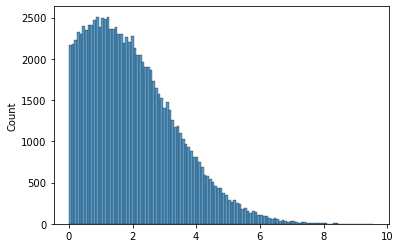

In [12]:
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import seaborn as sns

# simulate from truncated normal
key = random.PRNGKey(0)
mu = jnp.array(1.)
sigma = jnp.array(2.)
n = 100000
x = mu + sigma * random.truncated_normal(key, lower=-mu/sigma, upper=jnp.inf, shape = (n,))
sns.histplot(x)

# check logcdf
(jnp.log(jnp.array(1.) - jsp.stats.norm.cdf(-mu/sigma)), jsp.stats.norm.logcdf(mu/sigma))